In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import time
torch.manual_seed(101)

In [ ]:
Transform = transforms.ToTensor()

In [10]:
train = datasets.MNIST(root='./DATA', train=True, download=True, transform=Transform)
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./DATA
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
test = datasets.MNIST(root='./DATA', train=False, download=True, transform=Transform)
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./DATA
    Split: Test
    StandardTransform
Transform: ToTensor()

In [12]:
image, label = train[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


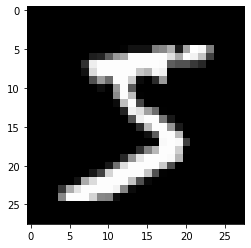

In [13]:
plt.imshow(image.reshape((28,28)), cmap="gray")

In [14]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)
test_loader = DataLoader(test, batch_size=500, shuffle=False)

In [15]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[120,84]):
        super().__init__()
        self.d1 = nn.Linear(input_size,layers[0])
        self.d2 = nn.Linear(layers[0],layers[1])
        self.d3 = nn.Linear(layers[1],output_size)

    def forward(self,X):
        X = F.relu(self.d1(X))
        X = F.relu(self.d2(X))
        X = self.d3(X)
        return F.log_softmax(X, dim=1)

In [16]:
model = MultilayerPerceptron()
print(model)

MultilayerPerceptron(
  (d1): Linear(in_features=784, out_features=120, bias=True)
  (d2): Linear(in_features=120, out_features=84, bias=True)
  (d3): Linear(in_features=84, out_features=10, bias=True)
)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
for images, labels in train_loader:
    print('Initial Batch shape:', images.size())
    break
print('Batch shape after flattening',images.view(100,-1).size())

Initial Batch shape: torch.Size([100, 1, 28, 28])
Batch shape after flattening torch.Size([100, 784])


In [23]:
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Apply the model
        y_pred = model(X_train.view(100, -1)) # Here we flatten X_train
        loss = criterion(y_pred, y_train)

        # Calculate the number of correct predicates
        predicted = torch.max(y_pred.data, 1)[1] # the prediction that has the maximum probability
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad() # reset the gradients after each training step
        loss.backward() # to trigger backprop
        optimizer.step() # perform parameter update

        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{100*b:6}/60000] Train loss: {loss.item():10.8f}')

        # Update train loss & accuracy for the epoch
        train_losses.append(loss)
        train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

            # Update test loss & accuracy for the epoch
            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(tst_corr)



epoch:  0 batch:  600 [ 60000/60000] Train loss: 0.00848768
epoch:  1 batch:  600 [ 60000/60000] Train loss: 0.00167116
epoch:  2 batch:  600 [ 60000/60000] Train loss: 0.03290074
epoch:  3 batch:  600 [ 60000/60000] Train loss: 0.00275277
epoch:  4 batch:  600 [ 60000/60000] Train loss: 0.00330073
epoch:  5 batch:  600 [ 60000/60000] Train loss: 0.00837239
epoch:  6 batch:  600 [ 60000/60000] Train loss: 0.00194393
epoch:  7 batch:  600 [ 60000/60000] Train loss: 0.00077747
epoch:  8 batch:  600 [ 60000/60000] Train loss: 0.00705084
epoch:  9 batch:  600 [ 60000/60000] Train loss: 0.00028349


In [21]:
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test accuracy: 97.810%


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

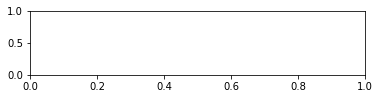

In [24]:
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')

plt.subplot(3, 1, 3)
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')

plt.legend()